In [10]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch
import config

from utils import show_abundance, plot_endmembers
from HySpecLab.metrics import rmse, sad
from scipy import io as sio

# Dataset 

In [11]:
from dataset import NerveFat
dataset = NerveFat(root_dir=config.NerveFat_PATH)
result_path = os.path.join(config.RESULTS_PATH, 'nerveFat')

In [16]:
def preprocessing(X:np.ndarray):
        '''
            Preprocessing the dataset for removing high-frequency noise. 
            This preprocessing consists of three steps:
                1. Median filter in the spatial domain.
                2. Moving average filter in the spectral domain. (No!)
                3. Normalization of the data.

            Parameters
            ----------
                X : np.ndarray, shape (nRow, nCol, nBand)
                    HSI Cube.
        '''
        from skimage.filters import median
        from utils import moving_average

        # X = median(X, footprint=np.ones((3,3,1)))
        # X = moving_average(X.reshape(-1, X.shape[-1]), 5, padding_size=4).reshape(X.shape[0], X.shape[1], -1)
        return X

X_filtered = preprocessing(dataset.X.reshape(dataset.n_row, dataset.n_col, -1))
dataset.X = torch.tensor(X_filtered.reshape(-1, X_filtered.shape[-1])).float()

/tmp/ipykernel_7599/1692831112.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset.X = torch.tensor(X_filtered.reshape(-1, X_filtered.shape[-1])).float()


In [17]:
# matlab_data = {
#     'X': dataset.image(),
#     'n_endmembers': dataset.n_endmembers,
#     'nRow': dataset.n_row,
#     'nCol': dataset.n_col,
#     'nBand': dataset.n_bands
# }

# sio.savemat(os.path.join(result_path, 'matlab/input.mat'), matlab_data)

In [18]:
test = dataset.image()

In [80]:
n_endmembers = 3

from HySpecLab.metrics import sad

def sort_endmember(endmembers, gt):
    sad_result = sad(endmembers, gt)
    e_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth
    return endmembers[e_idx], e_idx, sad_result

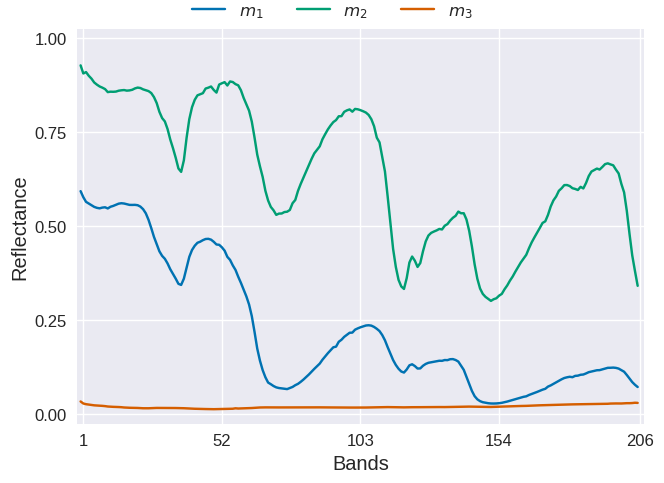

In [81]:
from HySpecLab.eea import VCA
   
vca = VCA(n_endmembers, snr_input=1, random_state=42)
vca.fit(dataset.X.numpy())
endmembers = torch.from_numpy(vca.endmembers()).float()

vca_endmember_init = endmembers
vca_logit_endmember_init = torch.log((vca_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(vca_endmember_init, ticks_range=(0, 1))
plt.show(fig)

fig.savefig(os.path.join(result_path, 'imgs/M_vca.pdf'), bbox_inches='tight')

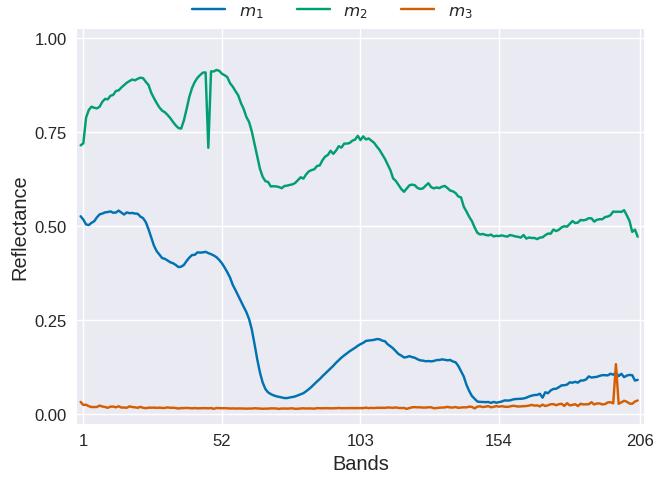

In [82]:
from utils import plot_endmembers
from pysptools import eea

ee = eea.NFINDR()
endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()

nfindr_endmember_init = endmember
nfindr_logit_endmember_init = torch.log((nfindr_endmember_init + 1e-12) / ((1-nfindr_endmember_init) + 1e-12))

nfindr_endmember_init, _, _ = sort_endmember(nfindr_endmember_init, vca_endmember_init)
nfindr_logit_endmember_init = torch.log((nfindr_endmember_init + 1e-12) / ((1-nfindr_endmember_init) + 1e-12))

fig = plot_endmembers(nfindr_endmember_init, ticks_range=(0, 1))
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/M_nfindr.pdf'), bbox_inches='tight')

In [96]:
# endmember_init_method = 'nfindr'
# endmember_init = nfindr_endmember_init
# logit_endmember_init = nfindr_logit_endmember_init

endmember_init_method = 'vca'
endmember_init = vca_endmember_init
logit_endmember_init = vca_logit_endmember_init

In [151]:
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
from HySpecLab.metrics import UnmixingLoss
from torch.utils.data import Dataset, DataLoader
from torch import sigmoid, nn
from tqdm import tqdm
import torch

def train(model:nn.Module, n_endmembers:int, dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3, similarity_weight=.5, simplex_weight=1e-5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    criterion = UnmixingLoss() 
    volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers).to(device)
    similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')
    vol_reg_norm = volume_reg(torch.sigmoid(model.ebk.detach()))

    dataloader = DataLoader(dataset, batch_size=int(len(dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )
    
    scaler = torch.cuda.amp.GradScaler()

    for _ in epoch_iterator:
        epoch_loss = 0.
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + simplex_weight*(volume_reg(sigmoid(model.ebk))/vol_reg_norm) + similarity_weight*similarity_reg(model.ebk)
            epoch_loss += loss.detach().item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)))

In [152]:
# from utils import train 
from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
train(model, n_endmembers, dataset, n_batchs=25, n_epochs=50, lr=1e-3, similarity_weight=1, simplex_weight=0)

100%|██████████| 50/50 [00:41<00:00,  1.20epoch/s, tls=0.0388]


# Save Model

In [153]:
torch.save(model.state_dict(), os.path.join(result_path, 'clhu/weights/clhu.pth'))

# Testing

In [164]:
from HySpecLab.unmixing import ContrastiveUnmixing

# load model
model = ContrastiveUnmixing(dataset.n_bands, n_endmembers)

model.load_state_dict(torch.load(os.path.join(result_path, 'clhu/weights/clhu.pth')))
model = model.eval()

In [165]:
model.eval()
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy

criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

In [166]:
from torch import sigmoid 
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(model.ebk).cpu())

tensor(0.0155) tensor(0.3061) tensor(116.4806) tensor(0.0156)


In [167]:
volume_reg(endmember_init), similarity_reg(logit_endmember_init)

(tensor(74.7529), tensor(0.0875))

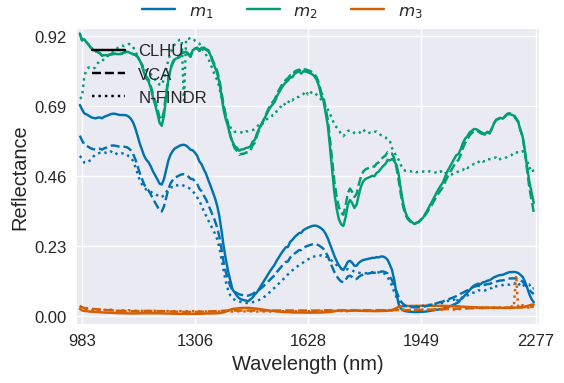

In [184]:
ebk = torch.sigmoid(model.ebk).detach()
fig = plot_endmembers(ebk, wv=dataset.wv, figsize=(6,4), ticks_range=(0, .92), endmember_estimation=[vca_endmember_init, nfindr_endmember_init], ee_labels=['CLHU', 'VCA', 'N-FINDR'])
# fig = plot_endmembers(ebk, wv=dataset.wv, ticks_range=(0, .8))
plt.show(fig)

fig.savefig(os.path.join(result_path, 'imgs/M_clhu.pdf'), bbox_inches='tight')

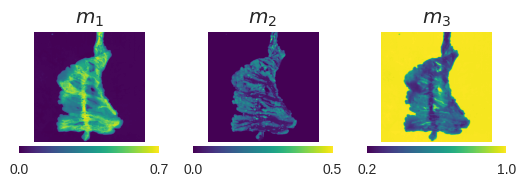

In [170]:
from torch.nn.functional import softmax
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, -1, order='F')

fig = show_abundance(test)
plt.show(fig)

fig.savefig(os.path.join(result_path, 'imgs/A_clhu.png'), dpi=300, bbox_inches='tight')
fig.savefig(os.path.join(result_path, 'imgs/A_clhu.pdf'), bbox_inches='tight')

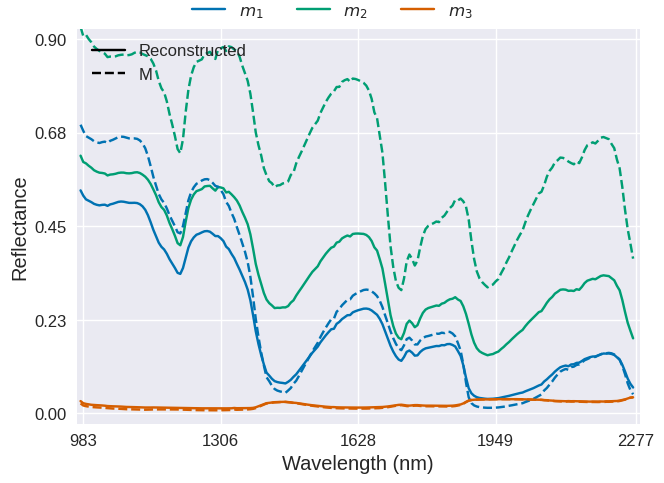

tensor([[6.8886e-01, 5.5902e-02, 2.5524e-01],
        [3.2381e-01, 4.1833e-01, 2.5786e-01],
        [7.8994e-03, 3.5131e-04, 9.9175e-01]])

In [161]:
M = sigmoid(model.ebk).detach()
M_hat = model(M).detach().cpu()

fig = plot_endmembers(M_hat, wv=dataset.wv, ticks_range=(0, .9), endmember_estimation=[M], ee_labels=['Reconstructed', 'M'])

plt.show(fig)

torch.softmax(model.A, dim=1).detach()

In [162]:
import torch 
n_endmembers=3
torch.vstack((torch.zeros((n_endmembers-1,)), torch.eye(n_endmembers-1)))

tensor([[0., 0.],
        [1., 0.],
        [0., 1.]])

In [37]:
from sklearn.decomposition import PCA
X = dataset.X
mu = X.reshape(-1, X.shape[-1]).mean(axis=0, keepdims=True).T
U = PCA(n_components=n_endmembers-1, random_state=42).fit(X.reshape(-1, X.shape[-1])).components_.T # (bands, endmembers-1)
U = torch.tensor(U, dtype=torch.float32)
mu.shape, U.shape

(torch.Size([206, 1]), torch.Size([206, 2]))

In [48]:
print(U.shape)

torch.Size([206, 2])


In [49]:
dataset.X.shape

torch.Size([68121, 206])

In [51]:
B = torch.vstack((torch.zeros((n_endmembers-1,)), torch.eye(n_endmembers-1)))
C = torch.zeros((n_endmembers, n_endmembers))
C[0, :] = 1
print(B)
print(C)
Z = C+B@U.T@(vca_endmember_init.T-mu)
print(Z)

tensor([[0., 0.],
        [1., 0.],
        [0., 1.]])
tensor([[1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor([[ 1.0000,  1.0000,  1.0000],
        [ 2.8989, -1.0058,  6.0180],
        [-0.6618, -0.0355,  1.4686]])


In [52]:
n_endmembers

3